<a href="https://colab.research.google.com/github/fares-mldev/uns-pdi2021/blob/main/tp7/PDI_TP7_Morphological_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP7 PROCESAMIENTO MORFOLÓGICO
Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:
- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura
-Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat

El elemento estructurante será de una ventana de 3x3 pixeles.
El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.
El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises.

Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.

**Nota**: La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.


In [10]:
#@title Imports

# Import numpy
import numpy as np

# Import imageio
import imageio as iio

# Import matplotlib
import matplotlib.pyplot as plt

# Import widgets
import ipywidgets as widgets
from IPython.display import display

# Install and import wget
!pip install wget
import wget


In [11]:
#@title Image utils

# Images URL list 
url_dict = {}
url_dict["bacteria"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/bacteria.jpg"
url_dict["head"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/head.jpg"
url_dict["retina"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/retina.jpg"
url_dict["dlines"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/dlines.jpg"

def get_image(image: str, fn="") -> np.array:
    '''
    Downloads specified image from the web and returns it as a numpy array
    '''
    # Read image from file
    img = iio.imread(url_dict[image]+fn)

    # Return image
    return np.asarray(img)

# RGB to YIQ space transformation matrix
rgb_to_yiq = [[0.299, 0.587, 0.114],
              [0.595716, -0.274453, -0.321263],
              [0.211456, -0.522591, 0.311135]]

# YIQ to RGB space transformation matrix
yiq_to_rgb = [[1, 0.9663, 0.6210],
              [1, -0.2721, -0.6474],
              [1, -1.1070, 1.7046]]

def plot_img(img: np.array, ax = None):
  '''
  Plots image using matplotlib 
  '''

  # If no axis sprecified get handle
  if ax is None:
    ax = plt.gca()

  # Show image
  ax.imshow(img)

def describe_img(img: np.array):
  '''
  Prints image properties
  '''
  print("Image shape (height,width,channels):", img.shape)
  print("Element type:", img.dtype)
  print("Total number of pixels:",img.size)
  print("Pixels per channel:", int(img.size/img.shape[2]))
  print("min-max value of channel 0:",img[:,:,0].min(),img[:,:,0].max())
  print("min-max value of channel 1:",img[:,:,1].min(),img[:,:,1].max())
  print("min-max value of channel 2:",img[:,:,2].min(),img[:,:,2].max())
  
def convert_rgb2yiq(img_rgb: np.array) -> np.array:
  '''
  Converts an RGB image to YIQ space
  '''
  
  # Normalize image
  img_rgb_n = img_rgb.astype(np.float64) / 255.0  
  
  # Apply transformation
  img_yiq = np.dot(img_rgb_n,rgb_to_yiq)
  
  # Clip to limits

  # Return YIQ image
  return img_yiq

def convert_yiq2rgb(img_yiq: np.array) -> np.array:
  '''
  Converts an YIQ image to RGB space
  '''

  # Apply transformation
  img_rgb_n= np.dot(img_yiq,yiq_to_rgb)
  
  # Clip image 
  img_rgb = img_rgb_n.clip(0,1) * 255.0
  
  # Return RGB image
  return img_rgb.astype(np.uint8) 

def get_y(im):
  '''
  Gets the luminance (Y) channel of an image
  '''
  return convert_rgb2yiq(im)[:,:,0]

def get_fft(im):
  '''
  Gets the magnitude and phase channels on an image
  '''
  fc = np.fft.fftshift(np.fft.fft2(im))

  mag = np.abs(fc)
  phase = np.angle(fc)

  return mag,phase

def get_ifft(fft_img):
    
  # reverse the 2D fourier transform
  img = np.fft.ifft2(np.fft.ifftshift(fft_img))
  img = np.abs(img)

  return img

def polar_to_rect(mag, phase):
  '''
  Recovers complex from magnitude and phase  
  '''
  return mag * np.exp(1j*phase)

def plot_fft(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude and phase
  '''
  fig, axes = plt.subplots(1,3)
  fig.set_size_inches(21,7)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')
  axes[2].imshow(phase, cmap = 'gray')
  axes[2].set_title('fft phase')
  
def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

def norm_img(im):
  '''
  Normalize image between 0 and 255.0
  '''
  return (im - np.min(im)) / (np.max(im) - np.min(im)) * 255.0

def plot_fft_mag(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude 
  '''
  fig, axes = plt.subplots(1,2)
  fig.set_size_inches(10,5)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')

def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

def plot_compare(im_orig,im_filt,name,operation):
  # Create figure
  fig, axes = plt.subplots(1,2)
  fig.set_size_inches(10,5)

  axes[0].imshow(im_orig, cmap = 'gray')
  axes[0].set_title(name + ' - original')

  axes[1].imshow(im_filt, cmap = 'gray')
  axes[1].set_title(name + ' - ' + operation)

In [12]:
#@title Morphological utils

def condition(im, ctype= "clip", invert= False):
  '''
  Apply signal conditioning
  '''
  assert ctype=="clip" or \
         ctype=="avg" or \
         ctype=="abs" or \
         ctype=="none", "Valid ctype values are 'clip', 'avg', 'abs' or 'none'" 

  # No conditioning
  if ctype=='none':
    return im
  
  if invert:
    im = -im.copy()
  
  # Stretch before conditioning  
  out = im / np.max(im)

  # Average
  if ctype == "avg":
    out = out / 2.0 + 0.5
  
  # Absolute
  if ctype == "abs":
    out = np.abs(out)
  
  # Clipping
  out = np.clip(out,0,1)

  return out 

def morph_2d(im, operation, *args):
  '''
  Perform convolution between an image and a 2d kernel
  '''

  # Prescale image
  im = im.copy() / im.max()

  # Get image shape
  im_h = im.shape[0] 
  im_w = im.shape[1] 

  # Get kernel shape
  k_h = 3
  k_w = 3

  # Remove central row-col and divide by 2
  pad_h = (k_h - 1) // 2
  pad_w = (k_w - 1) // 2
  
  # Create output image
  out = np.zeros(im.shape) 

  # Loop over rows
  for row in range(im_h):
    # Loop over cols
    for col in range(im_w):
      
      # Get sub image index ranges 
      range_w = range((col - pad_w), (col + pad_w + 1))
      range_h = range((row - pad_h), (row + pad_h + 1))
      
      # Clip to real indexes
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)
      
      # Slice image
      sub_im = im[np.ix_(idx_h,idx_w)]
      
      # Apply kernel
      out[row,col] = operation(sub_im, *args)

  return out


In [98]:
#@title Morphological operations

def morph_erode(x):
  '''
  Returns the minimum pixel value inside the structuring element
  '''
  return np.min(x)

def morph_dilate(x):
  '''
  Returns the minimum pixel value inside the structuring element
  '''
  return np.max(x)

def morph_edge_int(x: np.array):
  '''
  Substract the eroded image from the original image
  '''
  return x[1,1]-morph_erode(x)

def morph_edge_ext(x):
  '''
  Substract the original image from the dilated image
  '''
  return morph_dilate(x)-x[1,1]

def morph_median(x):
  '''
  Computes the median of the values inside the structuring element
  '''
  return np.median(x)

def morph_percentile(x,q=50):
  '''
  Computes the q-percentile of the values inside the structuring element
  '''
  return np.percentile(x, q)

def morph_tophat(x):
  '''
  Substract the opened image from the original image
  '''
  return x[1,1]-morph_open(x)


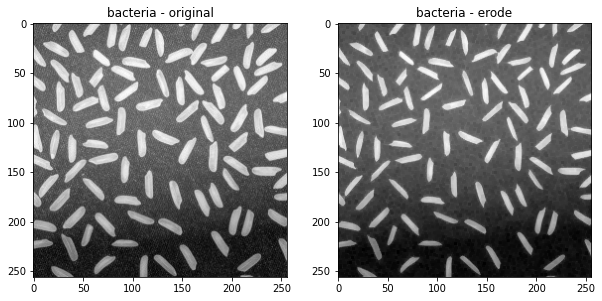

In [7]:
#@title Erode { run: "auto" }
#@markdown Returns the minimum pixel value inside the structuring element

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_erode)

# Plot result
plot_compare(im,im_filt,image,'erode')

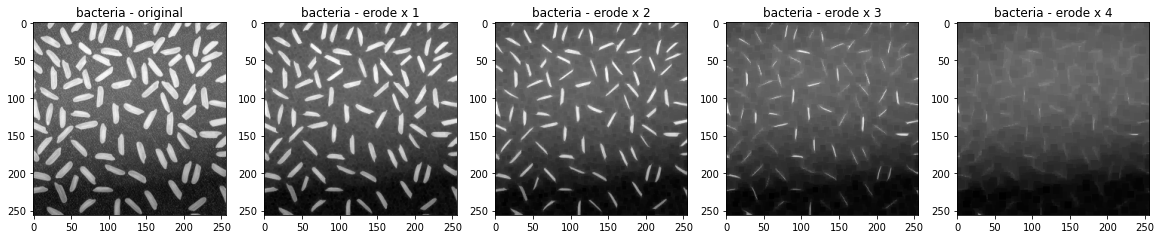

In [75]:
#@title Erode (Comparison) { run: "auto" }
#@markdown Computes the n succesive erode operations

image = "bacteria" #@param ["bacteria","head","retina"]
n = 4 

# Get image
im = get_y(get_image(image))

# Auxiliary function to get plot rw & col
def row_col(idx,n):
    col = idx%n
    row = idx//n
    return row , col 

# Setup figure
cols = n+1
rows = 1

fig , axes = plt.subplots(rows,cols)
fig.set_size_inches(20,10)

# Plot original image
axes[0].imshow(im, cmap = 'gray')
axes[0].set_title(image + ' - original')

# init image
im_filt = im

# Sweep over n values and plot resuts
for idx in range(n):

  # Apply filter
  im_filt = morph_2d(im_filt, morph_erode)

  # Plot filtered image
  axes[idx+1].imshow(im_filt, cmap = 'gray')
  axes[idx+1].set_title(image + ' - erode x ' + str(idx+1))

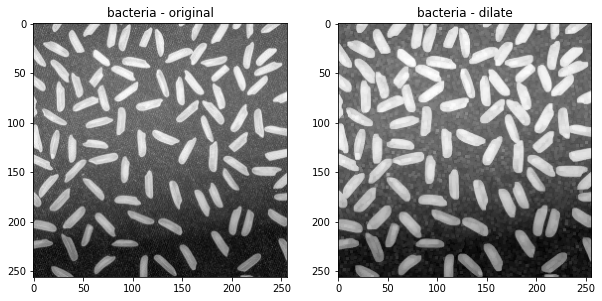

In [6]:
#@title Dilate { run: "auto" }
#@markdown Returns the maximum pixel value inside the structuring element

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_dilate)

# Plot result
plot_compare(im,im_filt,image,'dilate')

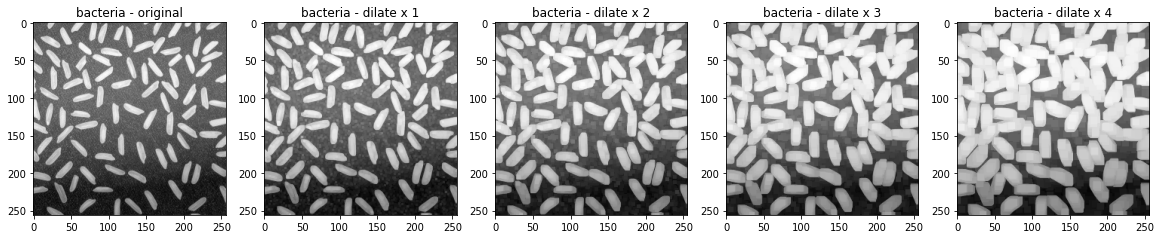

In [72]:
#@title Dilate (Comparison) { run: "auto" }
#@markdown Computes the n succesive erode operations

image = "bacteria" #@param ["bacteria","head","retina"]
n = 4 

# Get image
im = get_y(get_image(image))

# Auxiliary function to get plot rw & col
def row_col(idx,n):
    col = idx%n
    row = idx//n
    return row , col 

# Setup figure
cols = n+1
rows = 1

fig , axes = plt.subplots(rows,cols)
fig.set_size_inches(20,10)

# Plot original image
axes[0].imshow(im, cmap = 'gray')
axes[0].set_title(image + ' - original')

# init image
im_filt = im

# Sweep over n values and plot resuts
for idx in range(n):

  # Apply filter
  im_filt = morph_2d(im_filt, morph_dilate)

  # Plot filtered image
  axes[idx+1].imshow(im_filt, cmap = 'gray')
  axes[idx+1].set_title(image + ' - dilate x ' + str(idx+1))

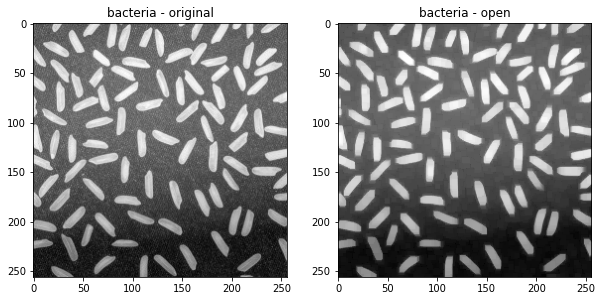

In [94]:
#@title Open { run: "auto" }
#@markdown Performs n erode operations followed by n dilate operations  

image = "bacteria" #@param ["bacteria","head","retina"]
n = 2 #@param {type:"slider", min:1, max:4, step:1}

# Get image
im = get_y(get_image(image))
im_filt = im

# Erode n times
for i in range(n):
  im_filt = morph_2d(im_filt, morph_erode)

# Dilate n times
for i in range(n):
  im_filt = morph_2d(im_filt, morph_dilate)

# Plot result
plot_compare(im,im_filt,image,'open')

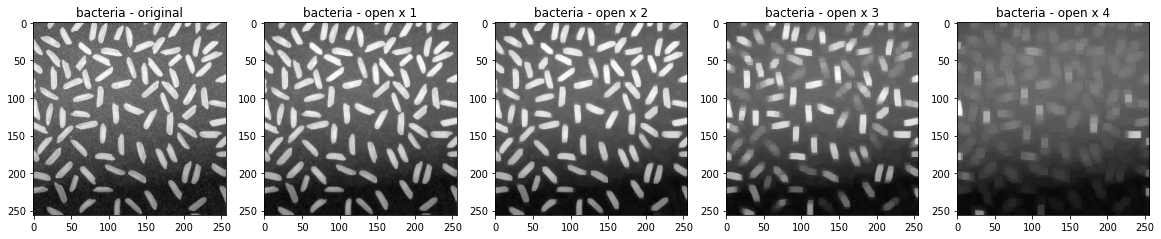

In [97]:
#@title Open (Comparison) { run: "auto" }
#@markdown Computes the n succesive erode operations

image = "bacteria" #@param ["bacteria","head","retina"]
n = 4 

# Get image
im = get_y(get_image(image))

# Auxiliary function to get plot rw & col
def row_col(idx,n):
    col = idx%n
    row = idx//n
    return row , col 

# Setup figure
cols = n+1
rows = 1

fig , axes = plt.subplots(rows,cols)
fig.set_size_inches(20,10)

# Plot original image
axes[0].imshow(im, cmap = 'gray')
axes[0].set_title(image + ' - original')

# init image
im_filt = im

# Sweep over n values and plot resuts
for idx in range(n):

  # init image
  im_filt = im

  # Erode n times
  for i in range(idx+1):
    im_filt = morph_2d(im_filt, morph_erode)

  # Dilate n times
  for i in range(idx+1):
    im_filt = morph_2d(im_filt, morph_dilate)

  # Plot filtered image
  axes[idx+1].imshow(im_filt, cmap = 'gray')
  axes[idx+1].set_title(image + ' - open x ' + str(idx+1))

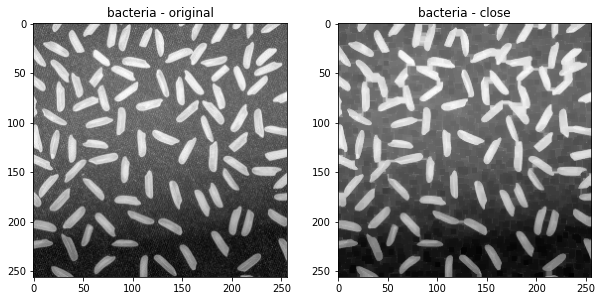

In [95]:
#@title Close { run: "auto" }
#@markdown Performs n dilate followed by n erode operations

image = "bacteria" #@param ["bacteria","head","retina"]
n = 2 #@param {type:"slider", min:1, max:4, step:1}

# Get image
im = get_y(get_image(image))
im_filt = im

# Dilate n times
for i in range(n):
  im_filt = morph_2d(im_filt, morph_dilate)

# Erode n times
for i in range(n):
  im_filt = morph_2d(im_filt, morph_erode)

# Plot result
plot_compare(im,im_filt,image,'close')

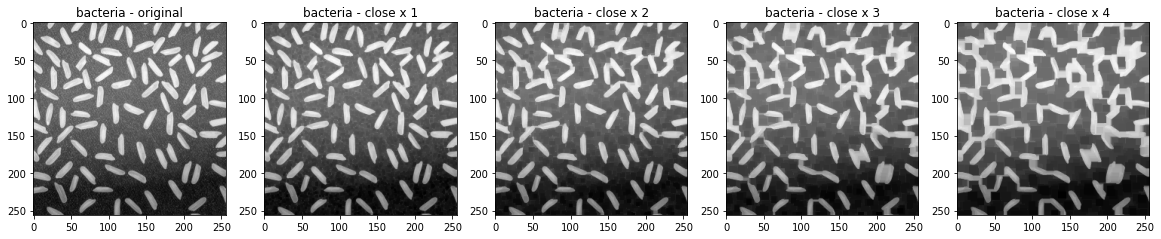

In [96]:
#@title Close (Comparison) { run: "auto" }
#@markdown Computes the n succesive erode operations

image = "bacteria" #@param ["bacteria","head","retina"]
n = 4 

# Get image
im = get_y(get_image(image))

# Auxiliary function to get plot rw & col
def row_col(idx,n):
    col = idx%n
    row = idx//n
    return row , col 

# Setup figure
cols = n+1
rows = 1

fig , axes = plt.subplots(rows,cols)
fig.set_size_inches(20,10)

# Plot original image
axes[0].imshow(im, cmap = 'gray')
axes[0].set_title(image + ' - original')

# Sweep over n values and plot resuts
for idx in range(n):

  # init image
  im_filt = im

  # Dilate n times
  for i in range(idx+1):
    im_filt = morph_2d(im_filt, morph_dilate)

  # Erode n times
  for i in range(idx+1):
    im_filt = morph_2d(im_filt, morph_erode)

  # Plot filtered image
  axes[idx+1].imshow(im_filt, cmap = 'gray')
  axes[idx+1].set_title(image + ' - close x ' + str(idx+1))

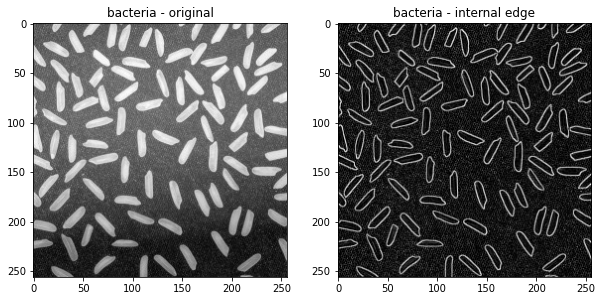

In [9]:
#@title Internal edge { run: "auto" }
#@markdown Substract the eroded image from the original image

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_edge_int)

# Plot result
plot_compare(im,im_filt,image,'internal edge')

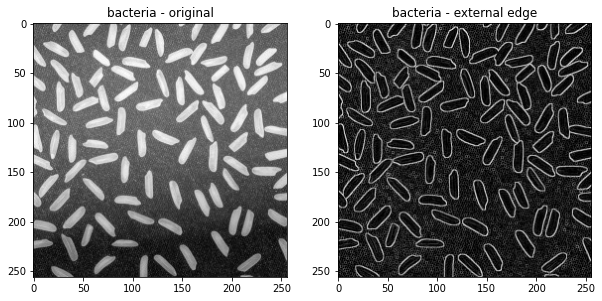

In [10]:
#@title External edge { run: "auto" }
#@markdown Substract the original image from the dilated image

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_edge_ext)

# Plot result
plot_compare(im,im_filt,image,'external edge')

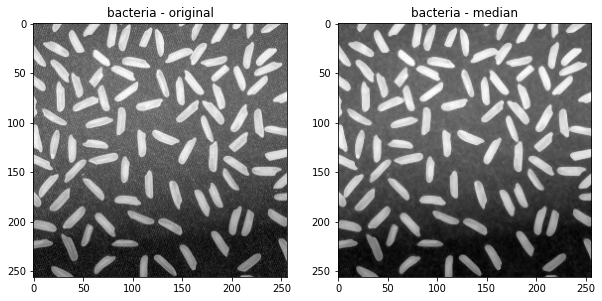

In [11]:
#@title Median { run: "auto" }
#@markdown Computes the median of the values inside the structuring element

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_median)

# Plot result
plot_compare(im,im_filt,image,'median')

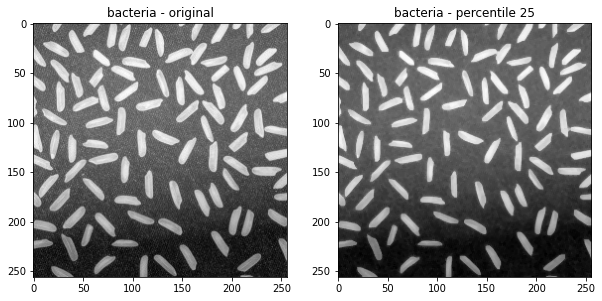

In [12]:
#@title Percentile { run: "auto" }
#@markdown Computes the q-percentile of the values inside the structuring element

image = "bacteria" #@param ["bacteria","head","retina"]
q = 25 #@param {type:"slider", min:0, max:100, step:5}

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_percentile,np.float64(q))

# Plot result
plot_compare(im,im_filt,image,'percentile ' + str(q))

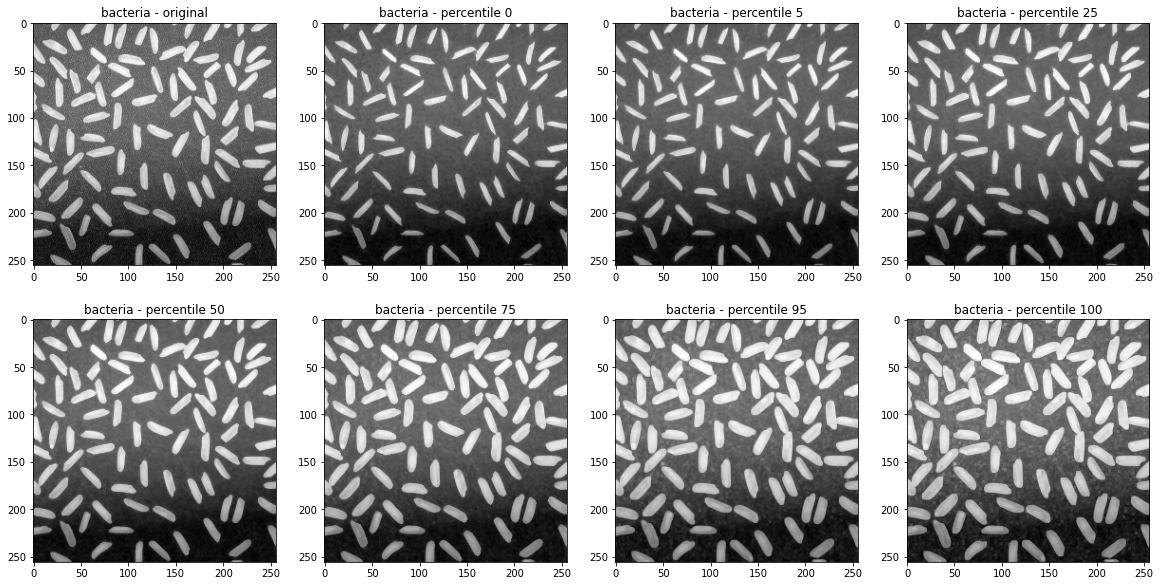

In [44]:
#@title Percentile (Comparison) { run: "auto" }
#@markdown Computes the q-percentile of the values inside the structuring element

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Auxiliary function to get plot rw & col
def row_col(idx,n):
    col = idx%n
    row = idx//n
    return row , col 

# q values
qs = [0,5,25,50,75,95,100]

# Setup figure
cols = 4
rows = (len(qs)+1)//cols

fig , axes = plt.subplots(rows,cols)
fig.set_size_inches(20,10)

# Plot original image
axes[0,0].imshow(im, cmap = 'gray')
axes[0,0].set_title(image + ' - original')

# Sweep over q values and plot resuts
for idx, q in enumerate(qs):
  # Apply filter
  im_filt = morph_2d(im, morph_percentile,q)

  row,col = row_col(idx+1,cols)

  # Plot filtered image
  axes[row,col].imshow(im_filt, cmap = 'gray')
  axes[row,col].set_title(image + ' - percentile ' + str(q))

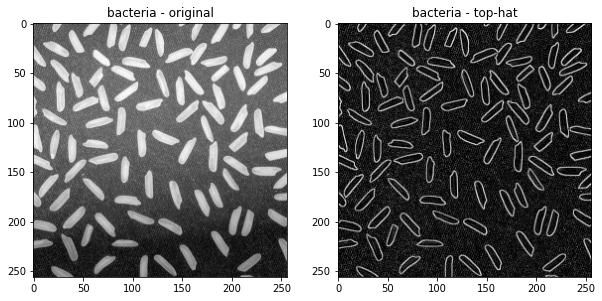

In [99]:
#@title Top-hat { run: "auto" }
#@markdown Substract the opened image from the original image

image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Apply filter
im_filt = morph_2d(im, morph_tophat)

# Plot result
plot_compare(im,im_filt,image,'top-hat')

Text(0.5, 1.0, 'bacteria - top-hat')

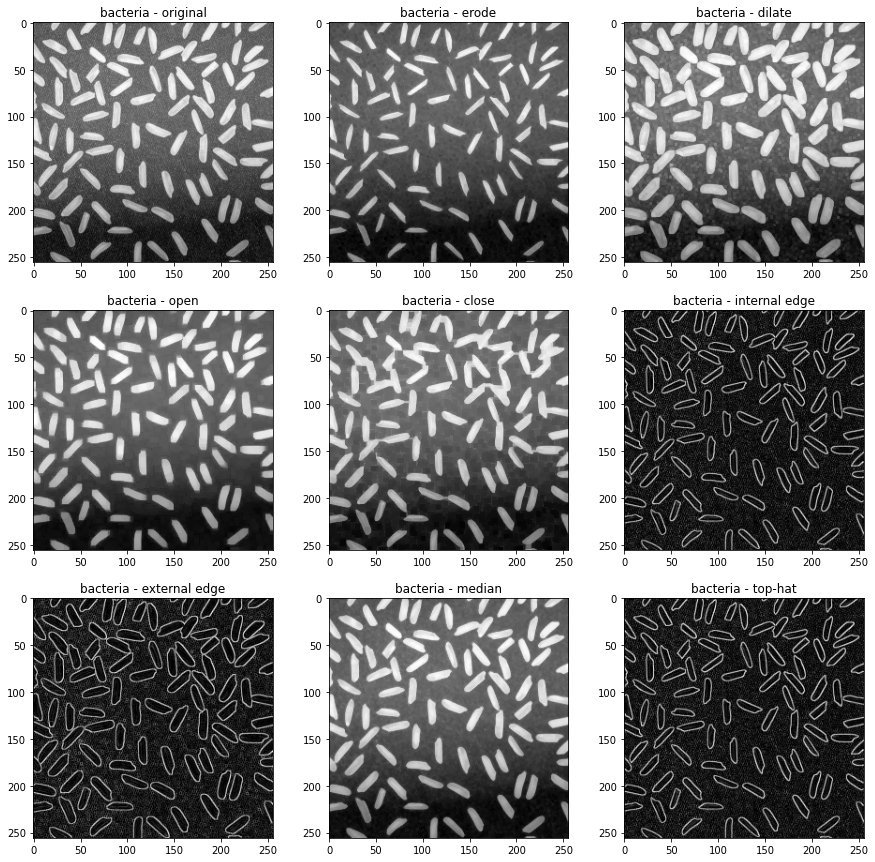

In [105]:
#@title Comparison plot { run: "auto" }
#@markdown Erode and Dilate alterate the size of objects by expanding/contracting the edges
#@markdown Open and Close alter the spacing of close objects without altering ther size
#@markdown Internal and External edges allow to detect borders in a robust manner. 
#@markdown The Median transform is good for low pass filtering, while the percentile filter allows to generate intermediate (and adjustable) effects between erode and dilate operations.



image = "bacteria" #@param ["bacteria","head","retina"]

# Get image
im = get_y(get_image(image))

# Comparison plot
fig , axes = plt.subplots(3,3)
fig.set_size_inches(15,15)

# Original
axes[0,0].imshow(im, cmap = 'gray')
axes[0,0].set_title(image + ' - original')

# Erode
im_filt = morph_2d(im, morph_erode)
axes[0,1].imshow(im_filt, cmap = 'gray')
axes[0,1].set_title(image + ' - erode')

# Dilate
im_filt = morph_2d(im, morph_dilate)
axes[0,2].imshow(im_filt, cmap = 'gray')
axes[0,2].set_title(image + ' - dilate')

# Open
im_filt = im
im_filt = morph_2d(im_filt, morph_erode)
im_filt = morph_2d(im_filt, morph_erode)
im_filt = morph_2d(im_filt, morph_dilate)
im_filt = morph_2d(im_filt, morph_dilate)
axes[1,0].imshow(im_filt, cmap = 'gray')
axes[1,0].set_title(image + ' - open')

# Close
im_filt = im
im_filt = morph_2d(im_filt, morph_dilate)
im_filt = morph_2d(im_filt, morph_dilate)
im_filt = morph_2d(im_filt, morph_erode)
im_filt = morph_2d(im_filt, morph_erode)
axes[1,1].imshow(im_filt, cmap = 'gray')
axes[1,1].set_title(image + ' - close')

# Internal edge
im_filt = morph_2d(im, morph_edge_int)
axes[1,2].imshow(im_filt, cmap = 'gray')
axes[1,2].set_title(image + ' - internal edge')

# External edge
im_filt = morph_2d(im, morph_edge_ext)
axes[2,0].imshow(im_filt, cmap = 'gray')
axes[2,0].set_title(image + ' - external edge')

# Median
im_filt = morph_2d(im, morph_median)
axes[2,1].imshow(im_filt, cmap = 'gray')
axes[2,1].set_title(image + ' - median')

# Top-hat
im_filt = morph_2d(im, morph_tophat)
axes[2,2].imshow(im_filt, cmap = 'gray')
axes[2,2].set_title(image + ' - top-hat')